# Adaptive AMPD (A-AMPD)
Here, we look into signals that are quasi-periodic locally, but have variable scale across the timeseries

In [1]:
import numpy as np
from numpy import sin, pi
from scipy.signal import find_peaks_cwt
from ampd import find_peaks_ampd
import matplotlib.pyplot as plt

## Create fake signal

In [2]:
def fake_timeseries(tmax=30, seed=None, dilation=1.):
    """Generate fake data for testing peak detection algorithms"""
    np.random.seed(seed)
    fs, f1, f2, f3 = 20, dilation * 1, dilation * 2, dilation * 0.1
    a, b, c, d = 1, 0.6, 1, 1.
    N = int(tmax*fs)
    t = np.linspace(0, tmax, N)
    x = a*sin(2*pi*f1*t) + b*sin(2*pi*f2*t) + c*sin(2*pi*f3*t) + d*np.random.rand(N)
    return t, x

## Compare peak detect methods

In [11]:
methods = [
    ('ampd', find_peaks_ampd),
    ('ampd_fast', lambda x: find_peaks_ampd(x, scale=50)),
    ('cwt', lambda x: find_peaks_cwt(x, widths=range(1,50))),
]
styles = ['rs', 'gx', 'mo']

### Create a signal with distinct regions characterised by different frequency/scale content

In [106]:
t1, x1 = fake_timeseries(tmax=30, seed=0)
t2, x2 = fake_timeseries(tmax=30, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [107]:
all_pks = [method(x) for name, method in methods]

Text(0,0.5,'signal')

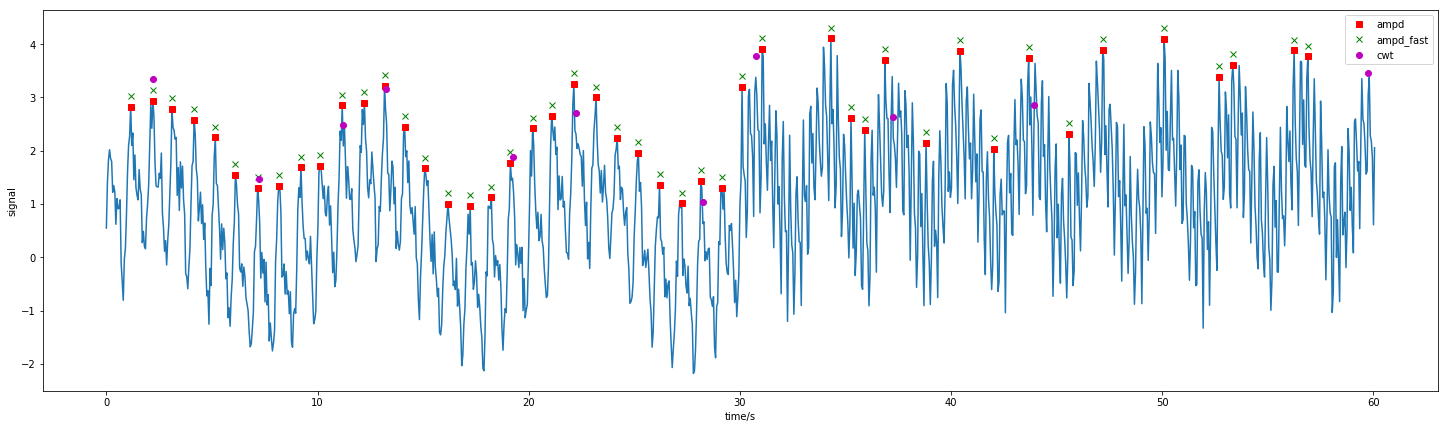

In [108]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
for idx in range(len(methods)):
    pks = all_pks[idx]
    offset = idx * 0.2
    style = styles[idx]
    name = methods[idx][0]
    plt.plot(t[pks], offset + x[pks], style, label=name)
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')

## Compare timing

In [25]:
t, x = fake_timeseries(tmax=300, seed=0)
print('{} samples over {} min'.format(len(x), t[-1]/60))

6000 samples over 5.0 min


In [26]:
for name, method in methods:
    print('timing "{}":'.format(name.upper()))
    %time pks = method(x)
    print()

timing "AMPD":
CPU times: user 264 ms, sys: 13.3 ms, total: 277 ms
Wall time: 71 ms

timing "AMPD_FAST":
CPU times: user 11.8 ms, sys: 1.17 ms, total: 13 ms
Wall time: 3.32 ms

timing "CWT":
CPU times: user 841 ms, sys: 45.3 ms, total: 887 ms
Wall time: 333 ms



## Adaptive LSM

In [57]:
from scipy.signal import convolve2d

In [58]:
t1, x1 = fake_timeseries(tmax=15, seed=0)
t2, x2 = fake_timeseries(tmax=15, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [59]:
pks, LSM, l = find_peaks_ampd(x, debug=True)

Text(0,0.5,'scale')

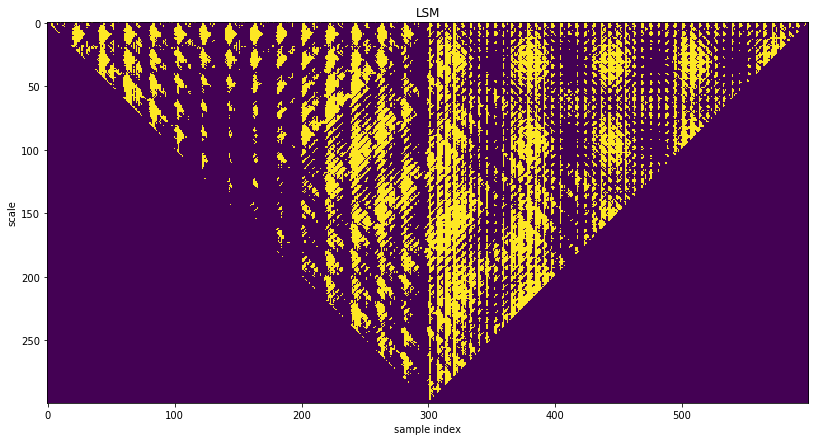

In [73]:
fig, ax0 = plt.subplots(ncols=1, figsize=(20, 7))
ax = ax0
ax.imshow(LSM)
ax.set_title('LSM')
ax.set_xlabel('sample index')
ax.set_ylabel('scale')

Text(0.5,1,'max @ 9')

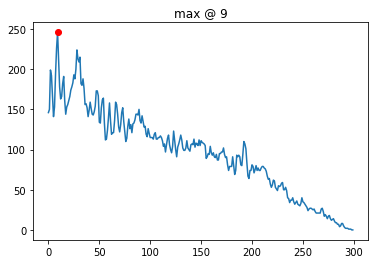

In [74]:
G = LSM.sum(axis=1)
plt.plot(G)
plt.plot(l, G[l], 'ro')
plt.title('max @ {}'.format(l))

In [96]:
scale = 200
kernel = np.ones((1, scale))
LSM_conv = convolve2d(LSM, kernel, mode='same') * np.arange(LSM.shape[0], 0, -1).reshape((-1, 1))

Text(0,0.5,'scale')

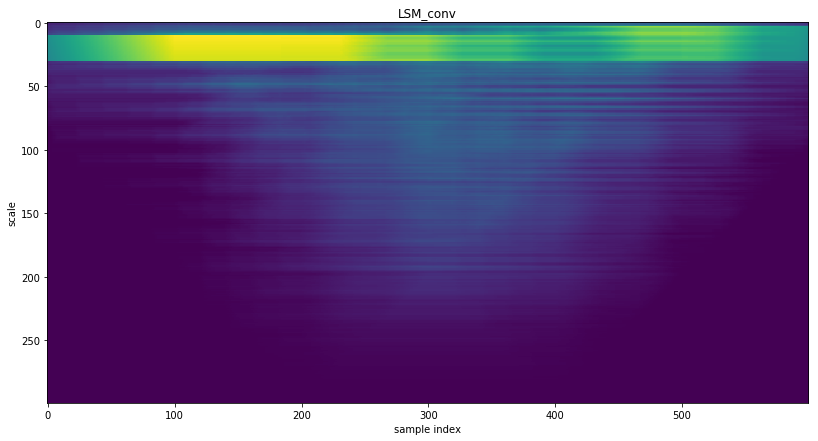

In [97]:
fig, ax0 = plt.subplots(ncols=1, figsize=(20, 7))
ax = ax0
ax.imshow(LSM_conv)
ax.set_title('LSM_conv')
ax.set_xlabel('sample index')
ax.set_ylabel('scale')

In [98]:
adaptive_scale = LSM_conv.argmax(axis=0)

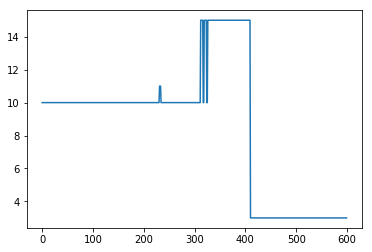

In [99]:
plt.plot(adaptive_scale)

In [100]:
LSM_reduced = LSM[:adaptive_scale.max(), :]

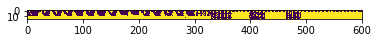

In [101]:
plt.imshow(LSM_reduced)

In [102]:
mask = np.indices(LSM_reduced.shape)[0] > adaptive_scale

LSM_reduced[mask] = 1

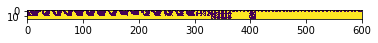

In [103]:
plt.imshow(LSM_reduced)

In [104]:
pks_logical = np.min(LSM[0:l, :], axis=0)
pks = np.nonzero(pks_logical)

Text(0,0.5,'signal')

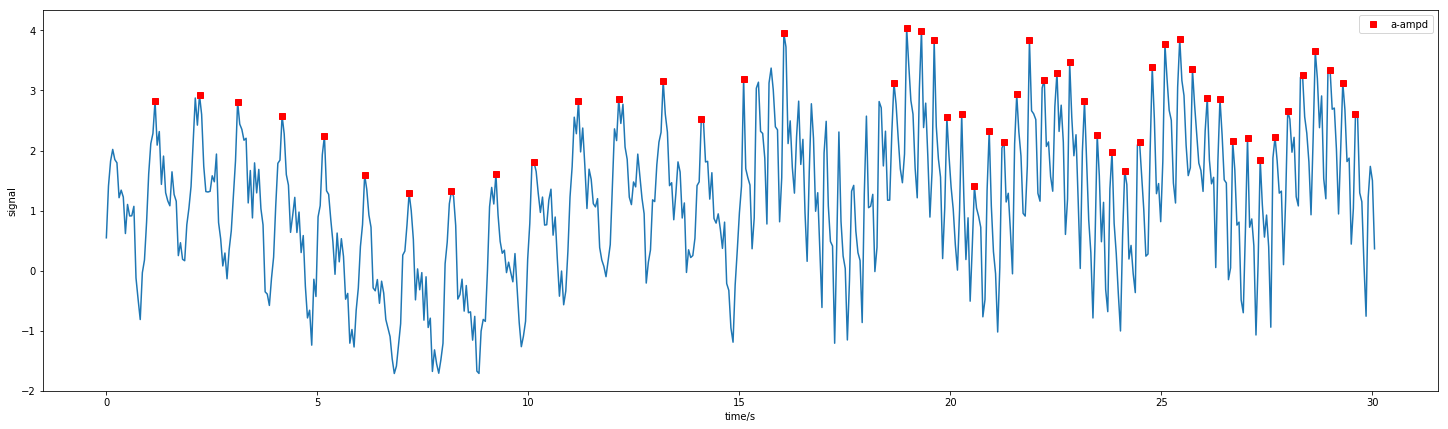

In [105]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
plt.plot(t[pks], x[pks], 'rs', label='a-ampd')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')